<a href="https://colab.research.google.com/github/Viwaz/Zindi_Competitions/blob/main/Financial_inclusion_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This Notebook got an MAE score of `0.112532222` which is higher than the previous one. I am yet to find out how to improve my model




# 📌 Financial Inclusion in Africa: Starter Notebook

This beginner-friendly guide walks you through a simple machine learning pipeline for predicting financial inclusion.


This is a simple starter notebook to get started with the Financial Inclusion Competition on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

In [1]:
# 📌 Import necessary libraries for data handling, visualization, and modeling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading The Data and exploring it

In [3]:
# 📥 Load datasets
train = pd.read_csv('Train.csv')  # Training dataset
test = pd.read_csv('Test.csv')  # Test dataset (no labels)
ss = pd.read_csv('SampleSubmission.csv')  # Sample submission format
variables = pd.read_csv('VariableDefinitions.csv')  # Data dictionary

# 📊 Check dataset shapes
print(f"✅ Train dataset: {train.shape[0]} rows, {train.shape[1]} columns")
print(f"✅ Test dataset: {test.shape[0]} rows, {test.shape[1]} columns")

✅ Train dataset: 23524 rows, 13 columns
✅ Test dataset: 10086 rows, 12 columns


From the above code we see that there are 13 features in the train DS and 12 in the test DS (test has the target variable excluded)

In [4]:
# Check for missing values in training data
print('train missing values:',"\n", train.isnull().sum())
print()
print('test missing values:',"\n", test.isnull().sum())

train missing values: 
 country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

test missing values: 
 country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


The both Data sets have no missing values

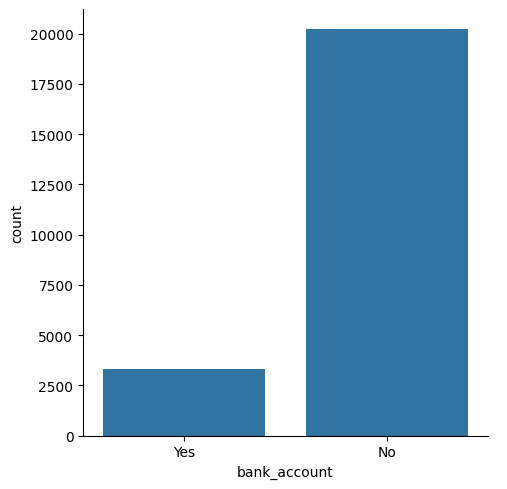

In [5]:
# Explore Target distribution
sns.catplot(x="bank_account", kind="count", data=train)

Distribution shows that there are more people without bank accounts

## Understanding the Data

In [ ]:
#show some information about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


There are 3 `numerical` features and the rest are `object` type
- `bank_account` and `cellphone_access` are ordinal hence can be handled accordingly
- Because `bank_account` is a target variable we can modify it seperately

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# features that need to be encode ordinally
ordinal_encoded_cols = ['cellphone_access', 'bank_account']
def ordinal_encoder(df):
    """
    Ordnally encodes the given columns, and returns the trasnformed Df
    :param df: DataFrame to be encoded
    :return: DataFrame with encoded columns
    """
    for col in df.columns:
        if col in ordinal_encoded_cols:
            df[col] = df[col].map({'No':0,'Yes':1})
    return df

# ordinal encoding
train = ordinal_encoder(train)
test = ordinal_encoder(test)


In [8]:
# getting numerical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
# getting categorical columns
X = train.drop(columns = ['bank_account', 'uniqueid'], axis = 1)
y = train.bank_account
test_mod = test.drop(columns = ['uniqueid'])

categorical_columns = [col for col in X.select_dtypes(include=['object']).columns if col not in ordinal_encoded_cols]
# Splitting the data into features and Target

In [9]:
# creating transformers
category_transformer = Pipeline(steps = [
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output= False))
])
# bundling tranformers to create an overal preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',category_transformer,categorical_columns)

    ]
)

#Splitiing the Data
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify = y)

In [10]:
# creating the piplines
Lgbm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, learning_rate=0.05))
])

Xg_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state = 42,tree_method="hist", enable_categorical=True, device="cuda"))
])

In [13]:
# Fitting the models and evaluating their perfomrmance
pipes = [Lgbm_pipe,Xg_pipe]
def evaluate_model(pipes):
    scores = {}
    for pipe in pipes:
        pipe.fit(X_train,y_train)
        pipe_name = pipe.named_steps['classifier'].__class__.__name__
        y_pred = pipe.predict(X_valid)

        err_score =accuracy_score(y_valid, y_pred)
        mae_score = mean_absolute_error(y_valid, y_pred)

        print(f"{pipe_name} error score: {err_score}")
        print(f"{pipe_name} mae score: {mae_score}")
        print()
        scores[err_score] = pipe
    return scores

scores = evaluate_model(pipes)




[LightGBM] [Info] Number of positive: 2650, number of negative: 16169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 18819, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140815 -> initscore=-1.808536
[LightGBM] [Info] Start training from score -1.808536
LGBMClassifier error score: 0.8888416578108396
LGBMClassifier mae score: 0.11115834218916047

XGBClassifier error score: 0.8867162592986185
XGBClassifier mae score: 0.1132837407013815



LGBM Classifier performed better than the XGBoost as such well use the former to train the whole data set

In [ ]:
Lgbm_pipe.fit(X,y)
test.bank_account = Lgbm_pipe.predict(test_mod)


[LightGBM] [Info] Number of positive: 3312, number of negative: 20212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 23524, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140792 -> initscore=-1.808724
[LightGBM] [Info] Start training from score -1.808724


#### Creating a doc for Submission

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})
submission.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [ ]:
# Create submission csv file csv file
submission.to_csv('second_submission.csv', index = False)
